<center><h1>San Francisco Crime Classification - Esembling</h1></center>

### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import random
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

### Data Reading

In [2]:
project_path = '/content/drive/MyDrive/AAIC/SCS-1/sf_crime_classification/'

In [3]:
train_sf_df = pd.read_csv(filepath_or_buffer=project_path + 'csv_files/train_data_features.csv')
df = pd.read_csv(filepath_or_buffer=project_path + 'csv_files/train.csv')

In [4]:
train_sf_df['category'] = df['Category']

In [5]:
train_sf_df.shape

(878049, 131)

### Stratification Split

* The data is highly imbalanced.

In [6]:
data = train_sf_df

In [7]:
X = data.drop(columns=['category'])
y = data['category']

### Data Preprocessing

In [8]:
def preprocess_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

In [9]:
X_norm = preprocess_data(X=X)

### Data Splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify=y, test_size=0.20)

In [11]:
len(y_train.value_counts()), len(y_test.value_counts())

(39, 39)

In [12]:
print("Training data shape : ", X_train.shape)
print("Test data shape : ", X_test.shape)

Training data shape :  (702439, 130)
Test data shape :  (175610, 130)


### Labels for Confusion Matrix

In [13]:
labels = [
    'ARSON',
    'ASSAULT',
    'BAD CHECKS',
    'BRIBERY',
    'BURGLARY',
    'DISORDERLY CONDUCT',
    'DRIVING UNDER THE INFLUENCE',
    'DRUG/NARCOTIC',
    'DRUNKENNESS',
    'EMBEZZLEMENT',
    'EXTORTION',
    'FAMILY OFFENSES',
    'FORGERY/COUNTERFEITING',
    'FRAUD',
    'GAMBLING',
    'KIDNAPPING',
    'LARCENY/THEFT',
    'LIQUOR LAWS',
    'LOITERING',
    'MISSING PERSON',
    'NON-CRIMINAL',
    'OTHER OFFENSES',
    'PORNOGRAPHY/OBSCENE MAT',
    'PROSTITUTION',
    'RECOVERED VEHICLE',
    'ROBBERY',
    'RUNAWAY',
    'SECONDARY CODES',
    'SEX OFFENSES FORCIBLE',
    'SEX OFFENSES NON FORCIBLE',
    'STOLEN PROPERTY',
    'SUICIDE',
    'SUSPICIOUS OCC',
    'TREA',
    'TRESPASS',
    'VANDALISM',
    'VEHICLE THEFT',
    'WARRANTS',
    'WEAPON LAWS'
 ]

### Confusion, Precision, and Recall Matrices

In [14]:
def plot_heatmap(matrix, title, labels, cmap='YlGnBu'):
    plt.figure(figsize=(25, 20))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return None

def plot_confusion_matrix(y_actuals, y_preds, labels=labels):
    # confusion matrix
    cmat = confusion_matrix(y_true=y_actuals, y_pred=y_preds)
    # precision matrix
    pmat = cmat / cmat.sum(axis=0)
    # recall matrix
    rmat = cmat / cmat.sum(axis=1)
    # class labels
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    
    return None

### Custom Stacking Classifier

In [17]:
class CustomStackingClassifier:
    def __init__(self, X_train, y_train, X_test, y_test, n_models):
        self.X_batch_1, self.X_batch_2, self.y_batch_1, self.y_batch_2 = train_test_split(
            X_train, y_train, stratify=y_train, random_state=42, test_size=0.5
        )

        print("X1 : ", self.X_batch_1.shape)
        print("X2 : ", self.X_batch_2.shape)

        self.X_test, self.y_test = X_test, y_test
        self.n_models = n_models

        # I am not considering SVM and KNN as the data is huge and highly imbalanced
        # It takes so much time to train and with less system requirements, 
        # I am considering the models which I trained prev after hyperparameter tuning
        self.available_model_names = ['logistic_regression', 'decision_tree', 'random_forest', 'xgboost']
        
        # `k` samples with replacement
        self.k_samples = []
        for i in range(self.n_models):
            each_k_indices = np.random.randint(low=0, high=self.X_batch_1.shape[0], size=self.X_batch_1.shape[0])
            each_k = np.matrix([self.X_batch_2[idx] for idx in each_k_indices])
            self.k_samples.append(each_k)
    
    def fit_base_models(self):
        predictions = []

        for sample in self.k_samples:
            model_name = random.choice(self.available_model_names)
            print("Fitting the base model :", model_name)

            if (model_name == 'logistic_regression'):
                model_path = project_path + 'models/log_reg_classifier.pkl'
            elif (model_name == 'decision_tree'):
                model_path = project_path + 'models/decision_tree_classifier.pkl'
            elif (model_name == 'random_forest'):
                model_path = project_path + 'models/random_forest_classifier.pkl'
            elif (model_name == 'xgboost'):
                model_path = project_path + 'models/xgboost_multi_classifier.pkl'
            
            model = pickle.load(open(model_path, 'rb'))
            k_predict_proba = model.predict_proba(sample)
            predictions.append(k_predict_proba)
        
        return np.hstack(tup=predictions)
    
    def fit_meta_model(self, meta_model, show_plot=True):
        model_path = project_path + 'models/'
        model_name = meta_model + '_stacking_classifer.pkl'

        if not os.path.isfile(path=model_path + model_name):
            X = self.fit_base_models()
            
            t_indicies = list(range(0, X.shape[1]))
            random.shuffle(t_indicies)
            X = X[:, t_indicies[:self.X_test.shape[1]]]
            print(X.shape)

            print('Fitting the meta model :', meta_model)

            if (meta_model == 'decision_tree'):
                clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
                clf.fit(X, self.y_batch_1)

                clf = CalibratedClassifierCV(clf, method='sigmoid')
                clf.fit(X, self.y_batch_1)
            
            elif (meta_model == 'xgboost'):
                clf = XGBClassifier(max_depth=8, n_estimators=150, objective='multi:softmax', tree_method='gpu_hist')
                clf.fit(X, self.y_batch_1)
            
            elif (meta_model == 'logistic_regression'):
                clf = LogisticRegression(penalty='l2', C=30, n_jobs=-1)
                clf.fit(X, self.y_batch_1)

                clf = CalibratedClassifierCV(clf, method='sigmoid')
                clf.fit(X, self.y_batch_1)
            
            elif (meta_model == 'random_forest'):
                clf = RandomForestClassifier(max_depth=8, n_estimators=100)
                clf.fit(X, self.y_batch_1)

                clf = CalibratedClassifierCV(clf, method='sigmoid')
                clf.fit(X, self.y_batch_1)

            y_batch_1_preds = clf.predict_proba(X)
            batch_log_loss = log_loss(self.y_batch_1, y_batch_1_preds)
            print("Training Log Loss:", batch_log_loss)

            y_test_preds = clf.predict_proba(self.X_test)
            test_log_loss = log_loss(self.y_test, y_test_preds)
            print("Testing Log Loss:", test_log_loss)
            
            pickle.dump(clf, open(model_path + model_name, 'wb'))
        
        else:
            print('Model already exists.')
            clf = pickle.load(open(model_path + model_name, 'rb'))

        if show_plot:
            predict_y = clf.predict(self.X_test)
            plot_confusion_matrix(y_actuals=self.y_test, y_preds=predict_y)
        
        classification_report = metrics.classification_report(self.y_test, predict_y)
        print(classification_report)

        return batch_log_loss, test_log_loss

### Object Creation

In [18]:
csc = CustomStackingClassifier(
    X_train, y_train, X_test, y_test, n_models=8
)

X1 :  (351219, 130)
X2 :  (351220, 130)


### XGBoost as a Meta Model

Fitting the base model : logistic_regression
Fitting the base model : decision_tree
Fitting the base model : decision_tree
Fitting the base model : xgboost
Fitting the base model : random_forest
Fitting the base model : random_forest
Fitting the base model : random_forest
Fitting the base model : decision_tree
(351219, 130)
Fitting the meta model : xgboost
Training Log Loss: 1.9570672108820373
Testing Log Loss: 3.721021658037129


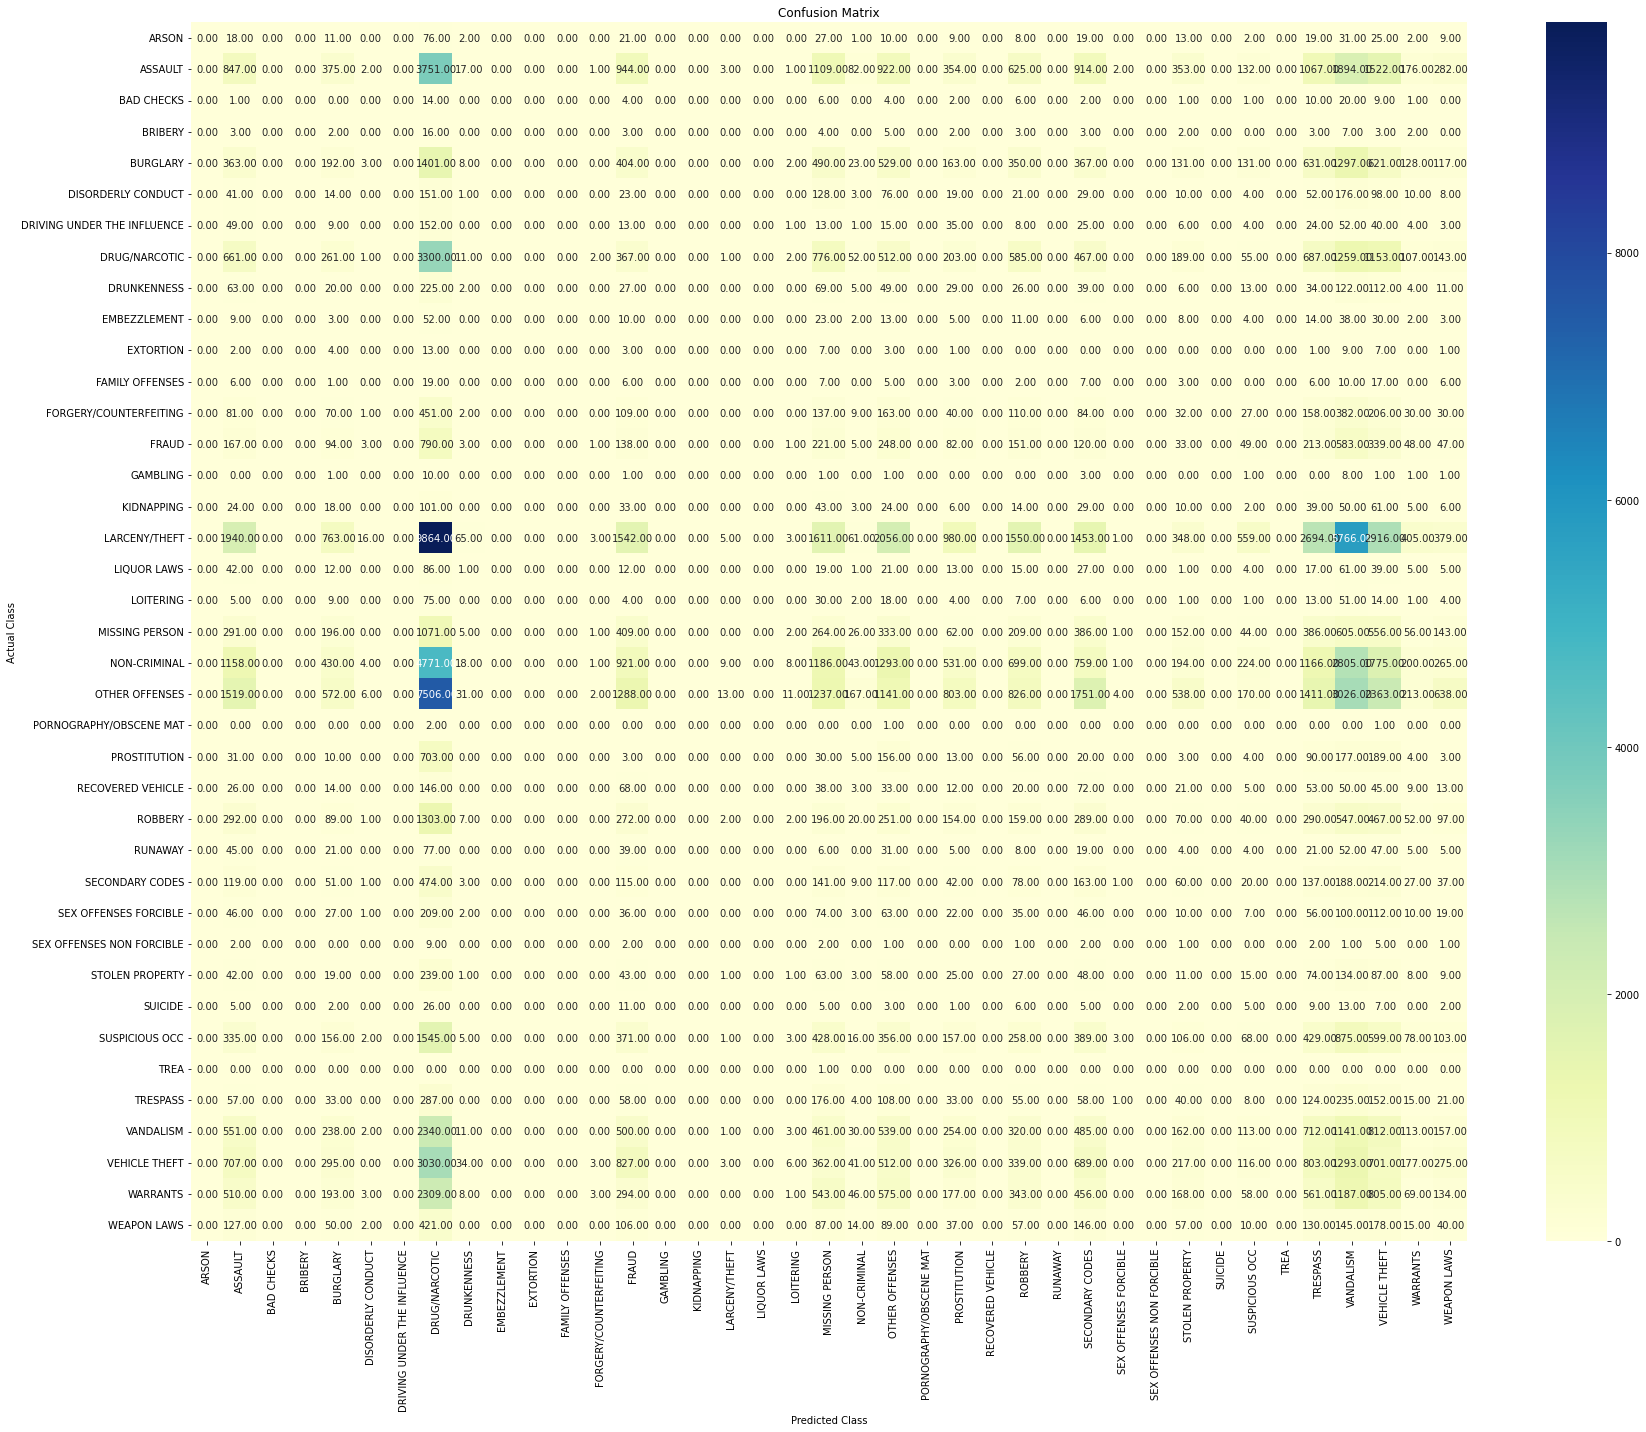

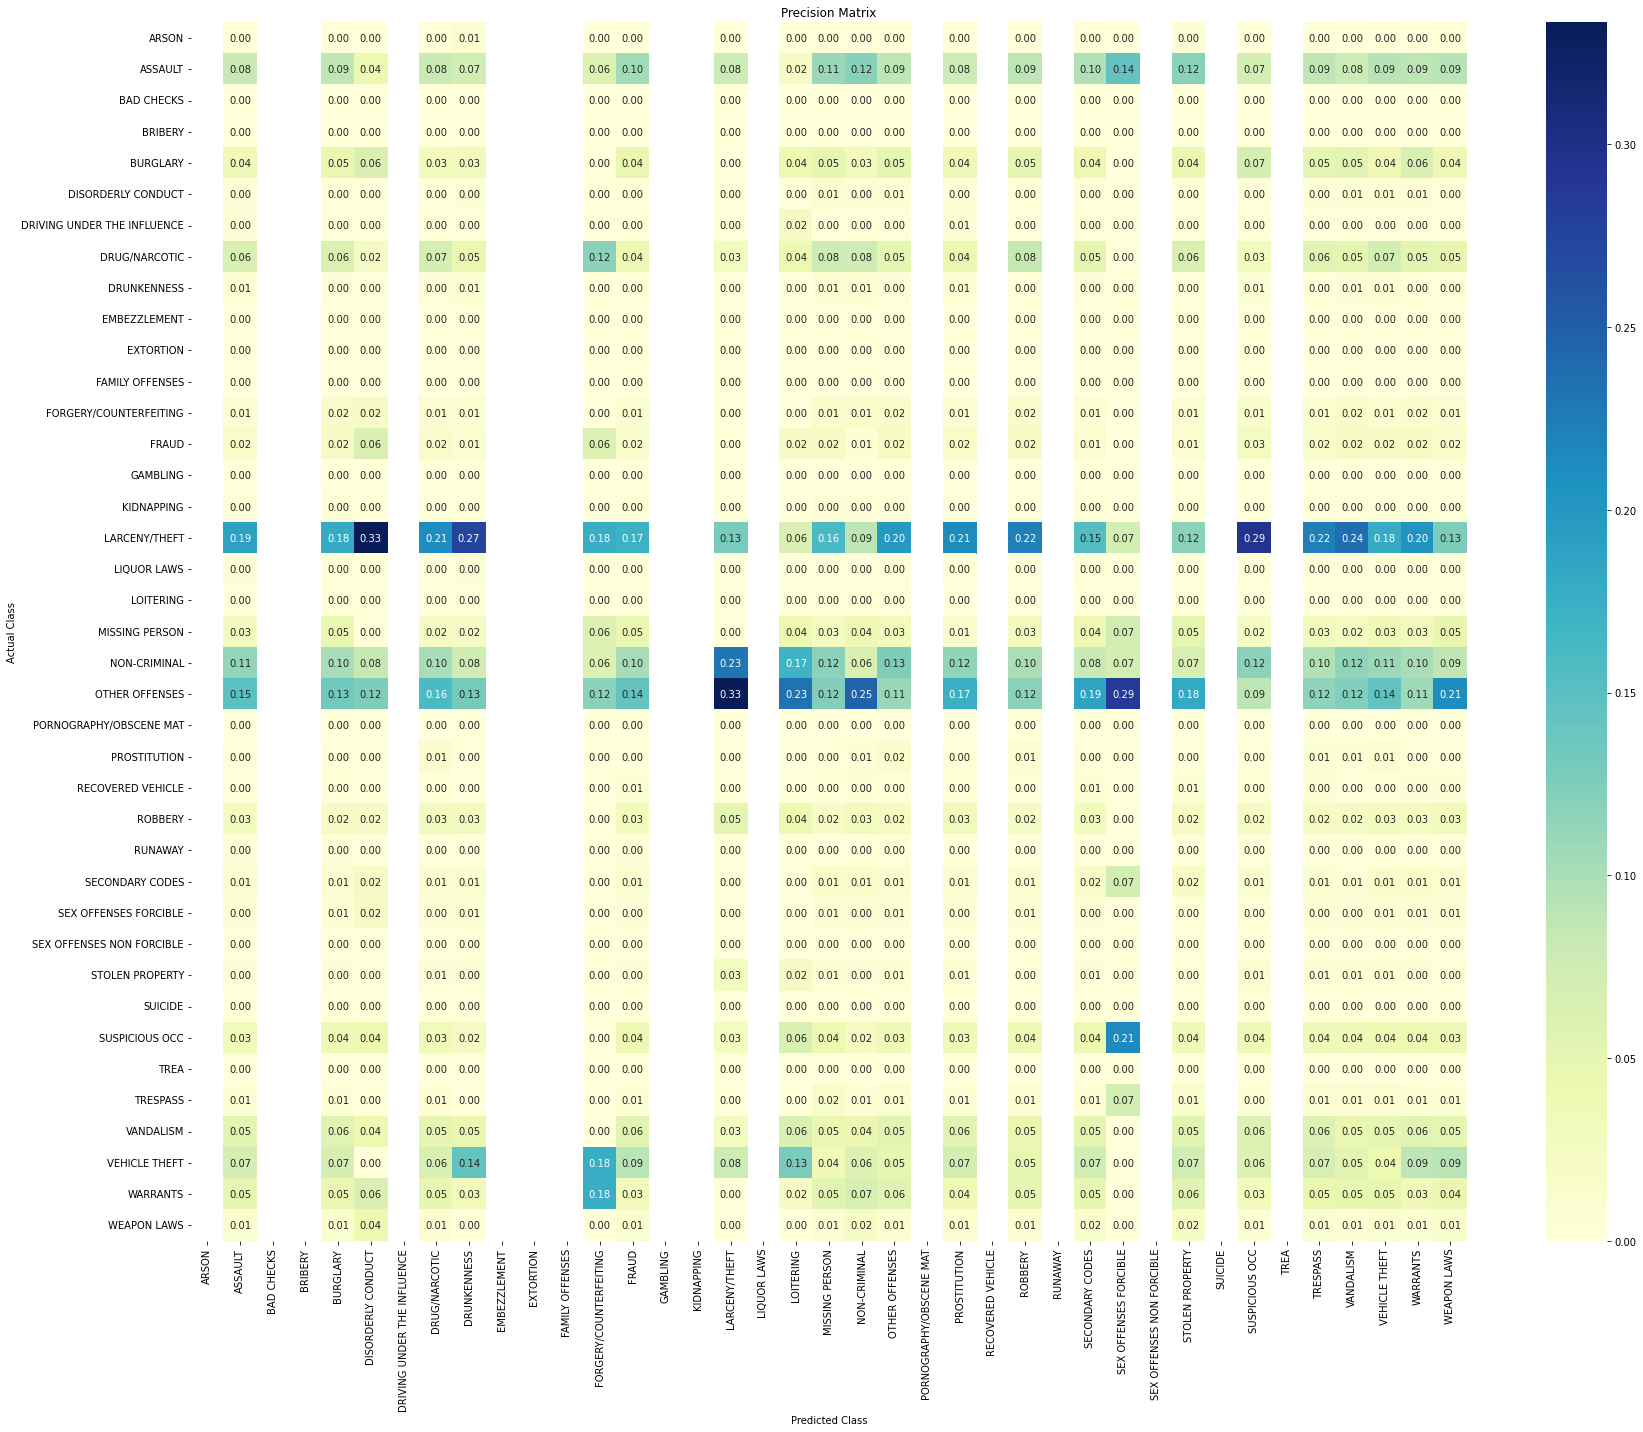

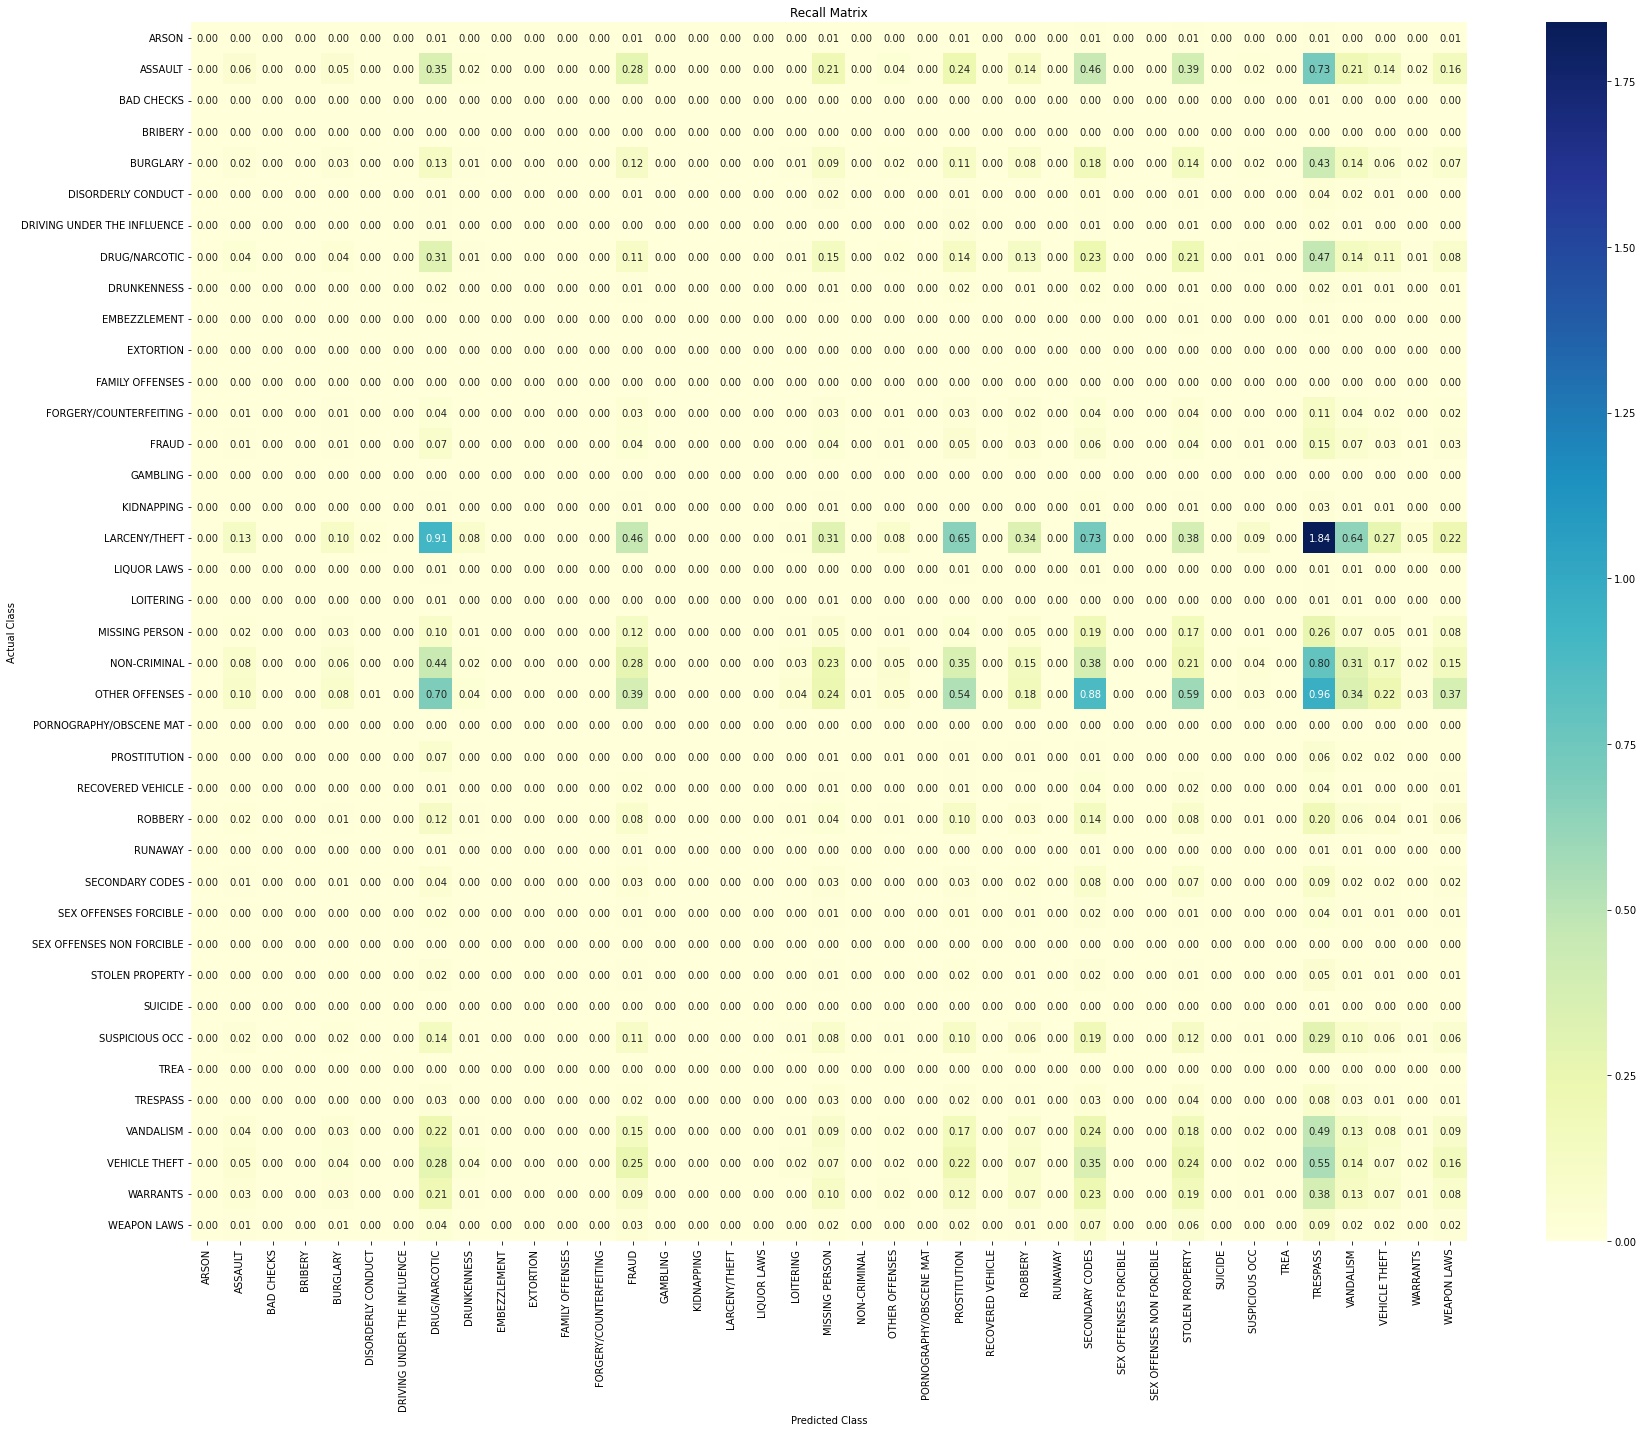

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.08      0.06      0.07     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.05      0.03      0.03      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.07      0.31      0.11     10794
                DRUNKENNESS       0.01      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [19]:
xgboost_stacked_train_loss, xgboost_stacked_test_loss = csc.fit_meta_model(meta_model='xgboost')

### Decision Tree as a Meta Model

Fitting the base model : xgboost
Fitting the base model : logistic_regression
Fitting the base model : logistic_regression
Fitting the base model : random_forest
Fitting the base model : random_forest
Fitting the base model : decision_tree
Fitting the base model : decision_tree
Fitting the base model : decision_tree
(351219, 130)
Fitting the meta model : decision_tree
Training Log Loss: 2.6815816948950353
Testing Log Loss: 2.6805453550254663


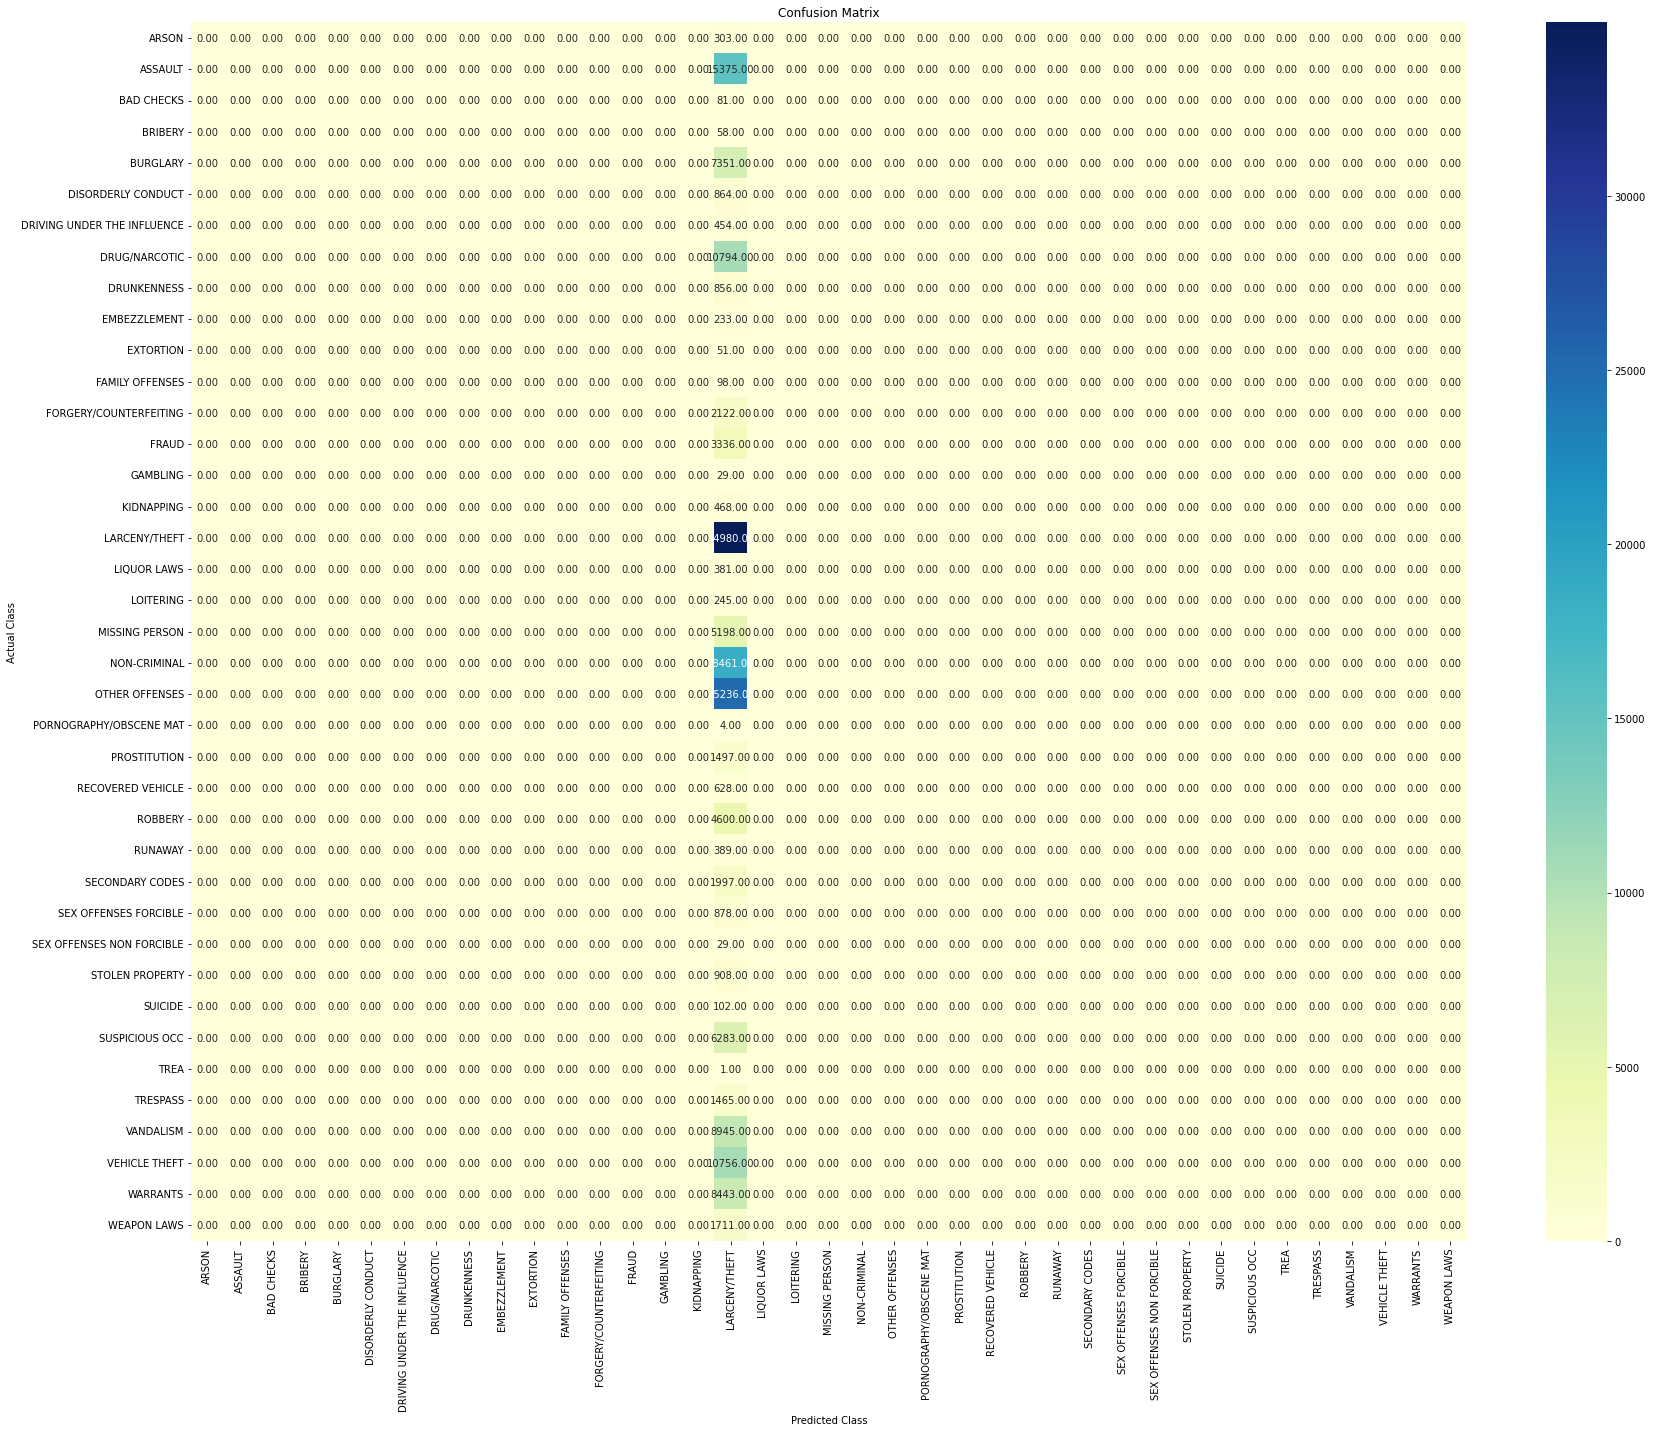

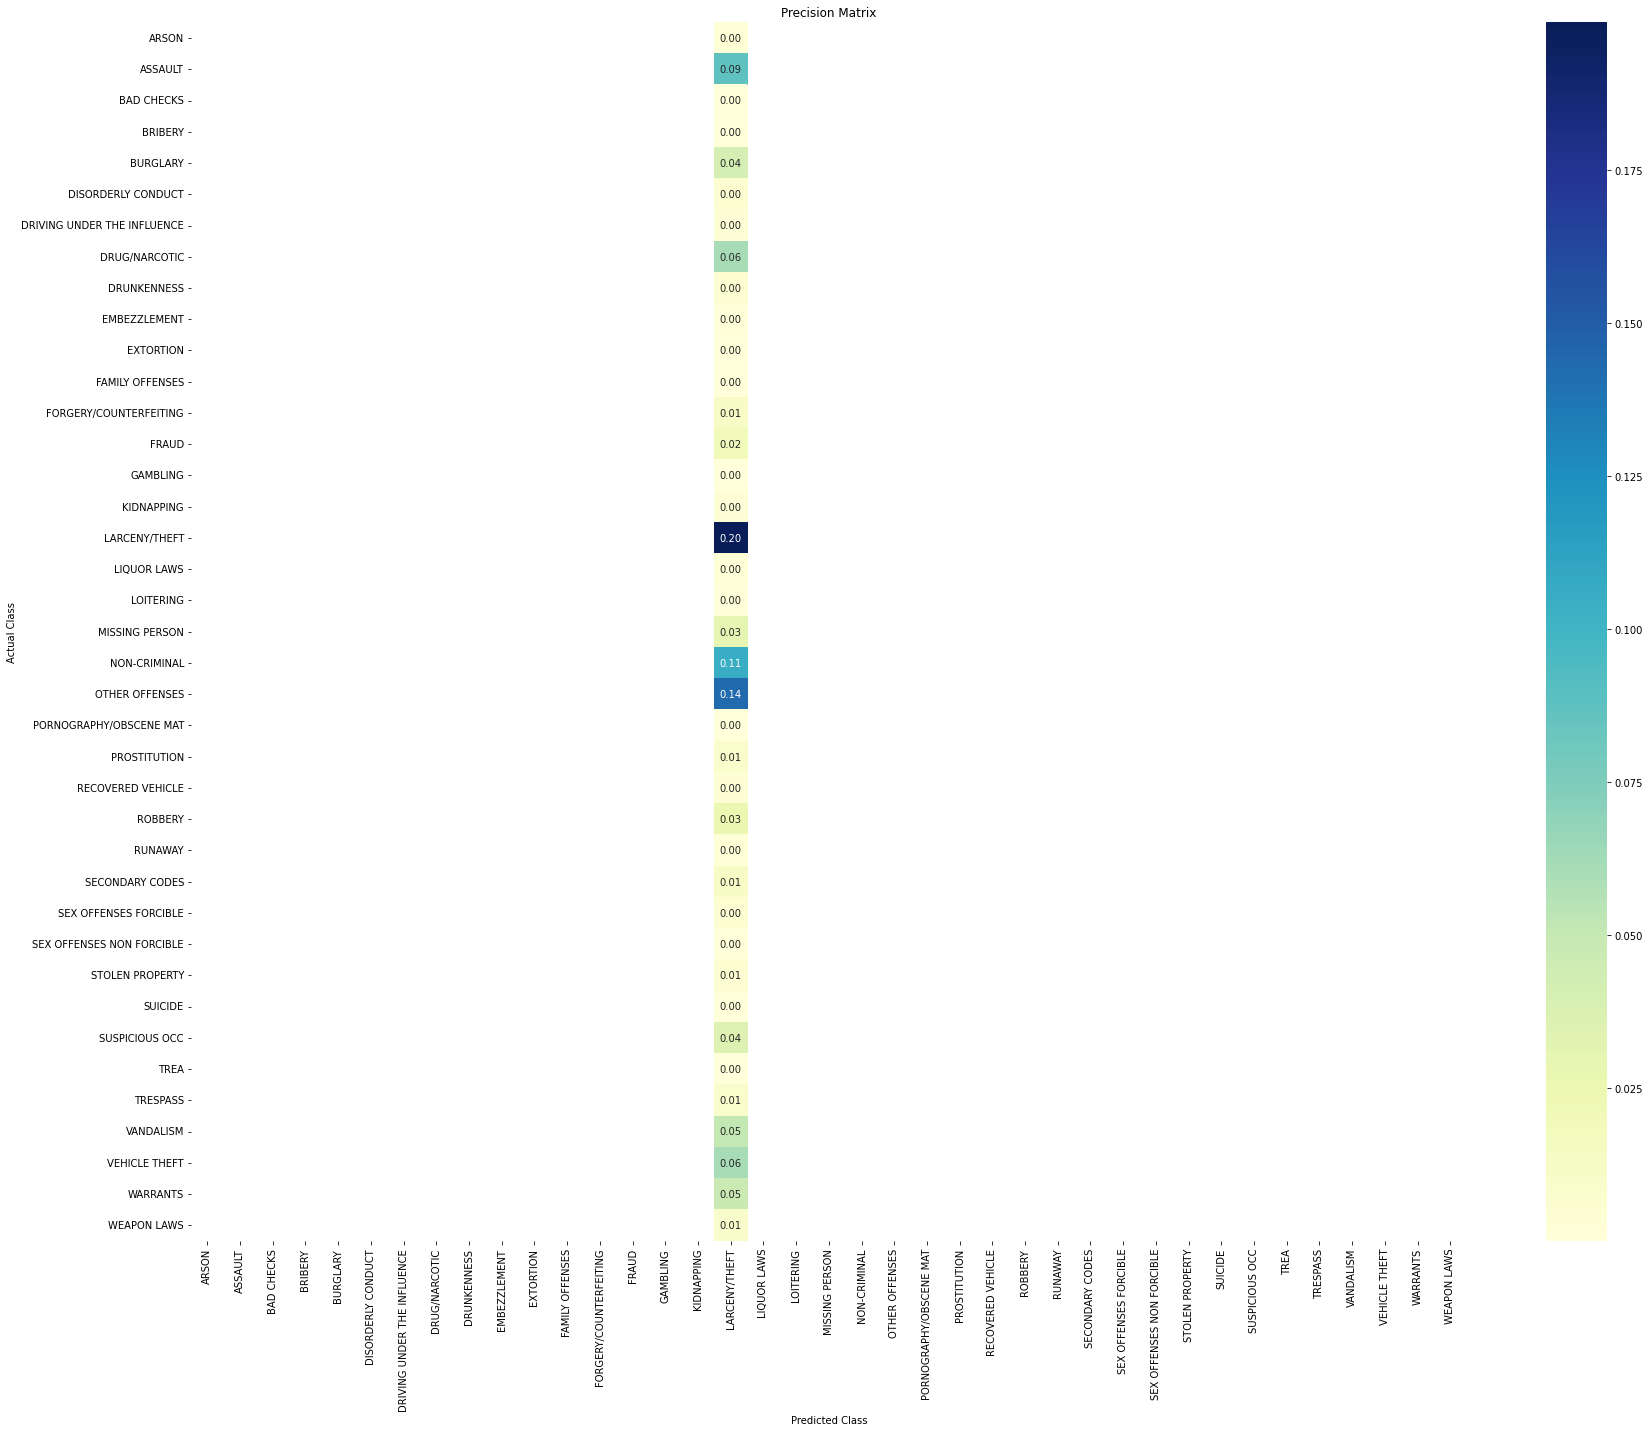

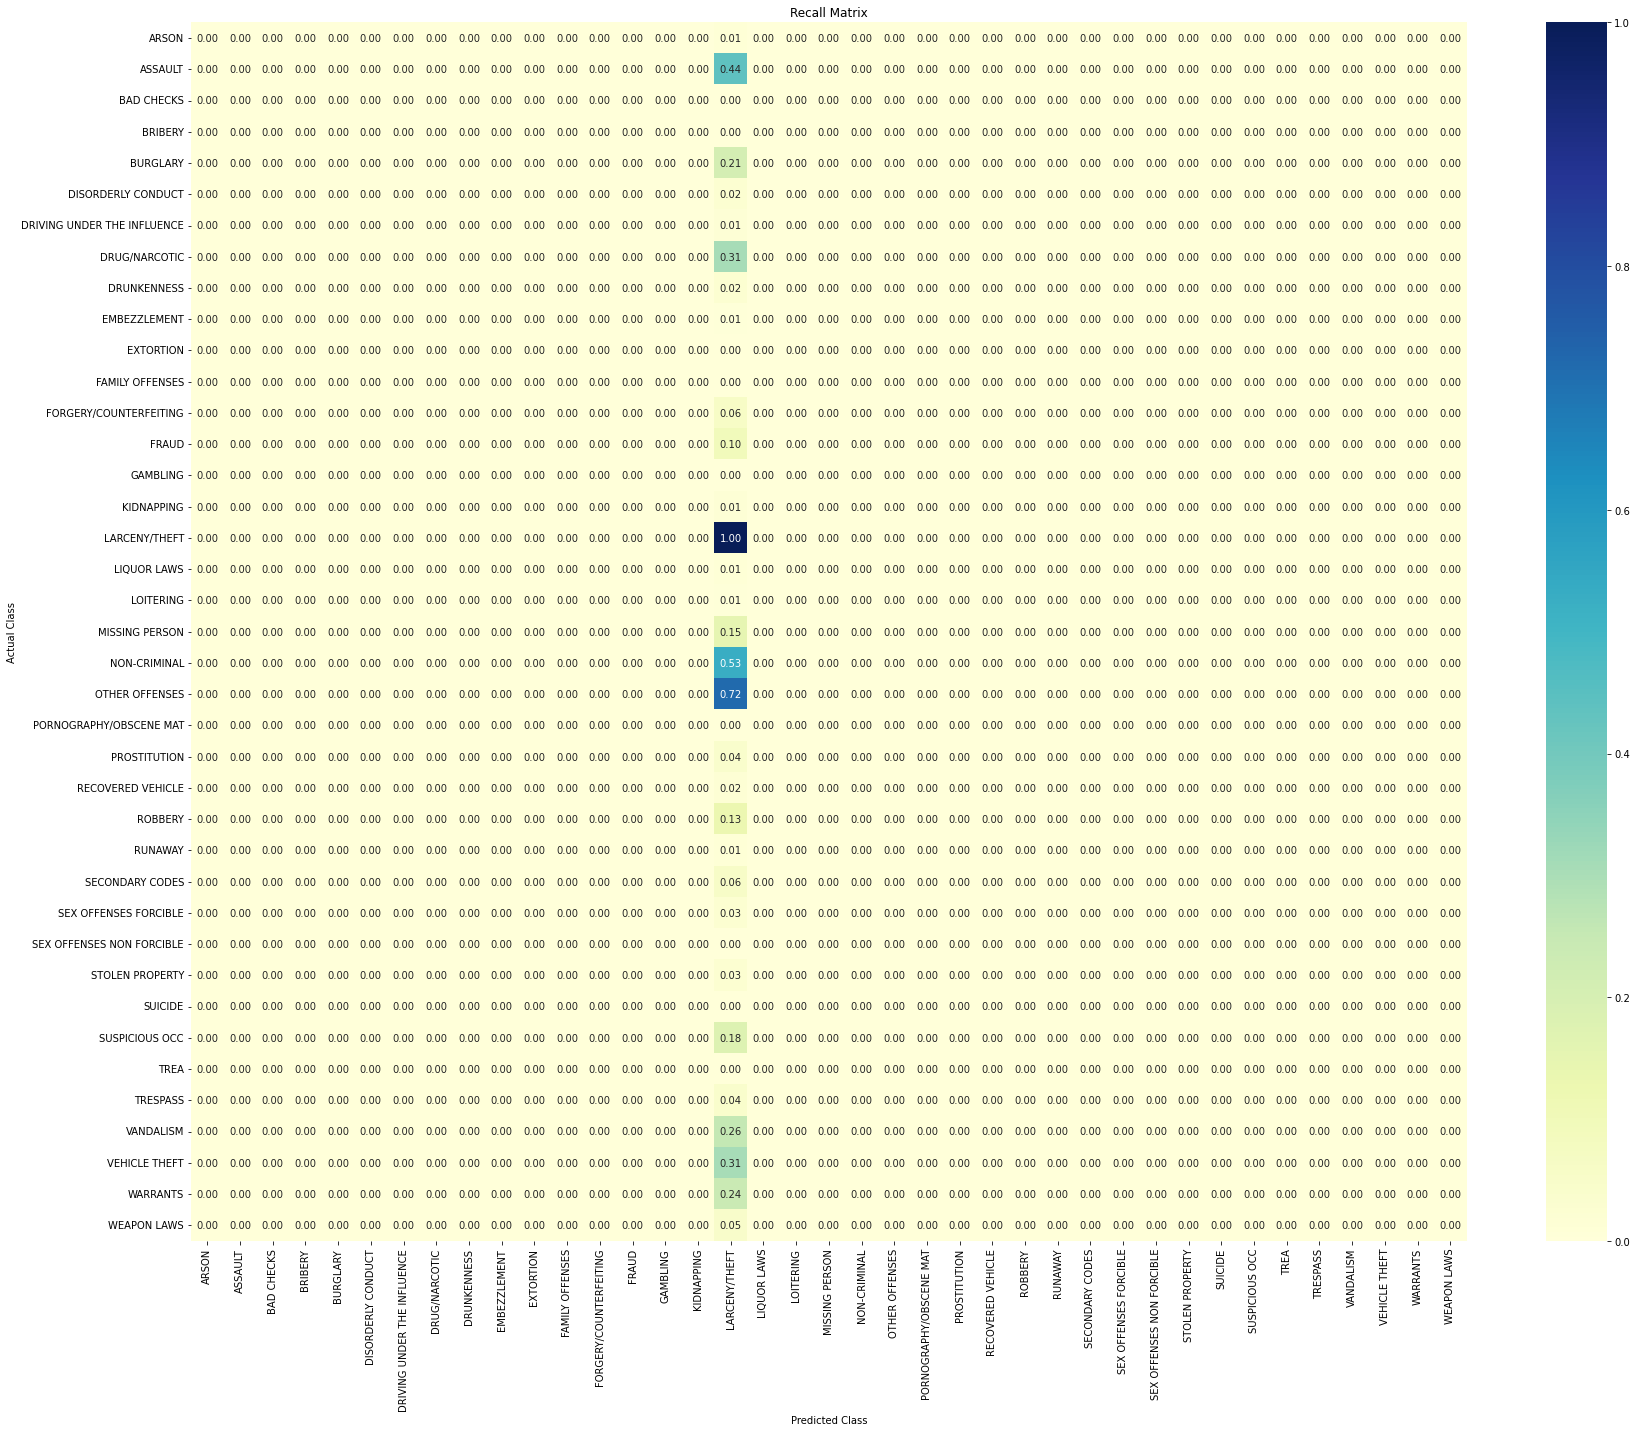

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.00      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.00      0.00      0.00     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [20]:
dt_stacked_train_loss, dt_stacked_test_loss = csc.fit_meta_model(meta_model='decision_tree')

### Logistic Regression as a Meta Model

Fitting the base model : decision_tree
Fitting the base model : decision_tree
Fitting the base model : decision_tree
Fitting the base model : xgboost
Fitting the base model : logistic_regression
Fitting the base model : decision_tree
Fitting the base model : random_forest
Fitting the base model : decision_tree
(351219, 130)
Fitting the meta model : logistic_regression
Training Log Loss: 2.6803187080404474
Testing Log Loss: 2.781042838206344


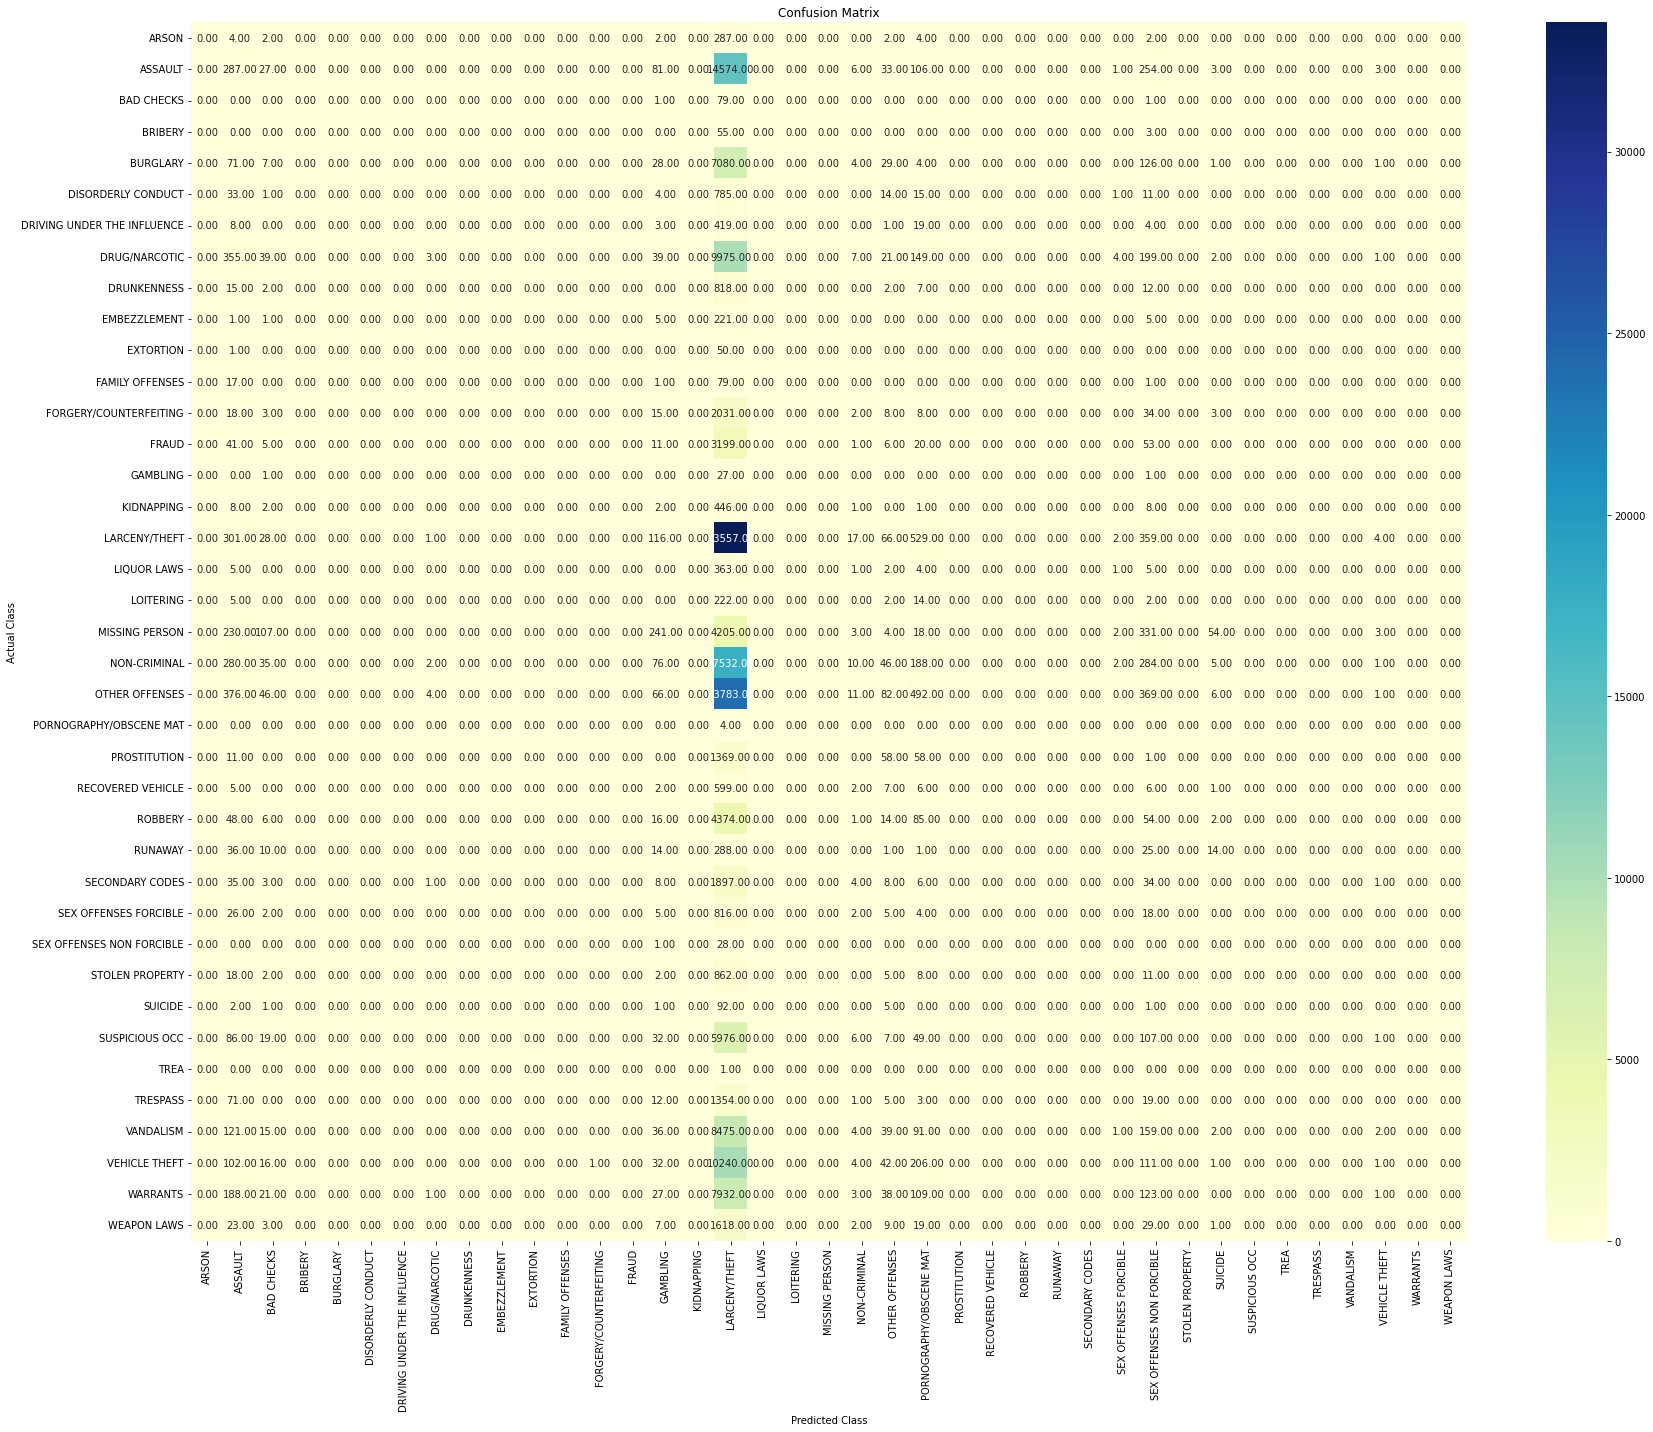

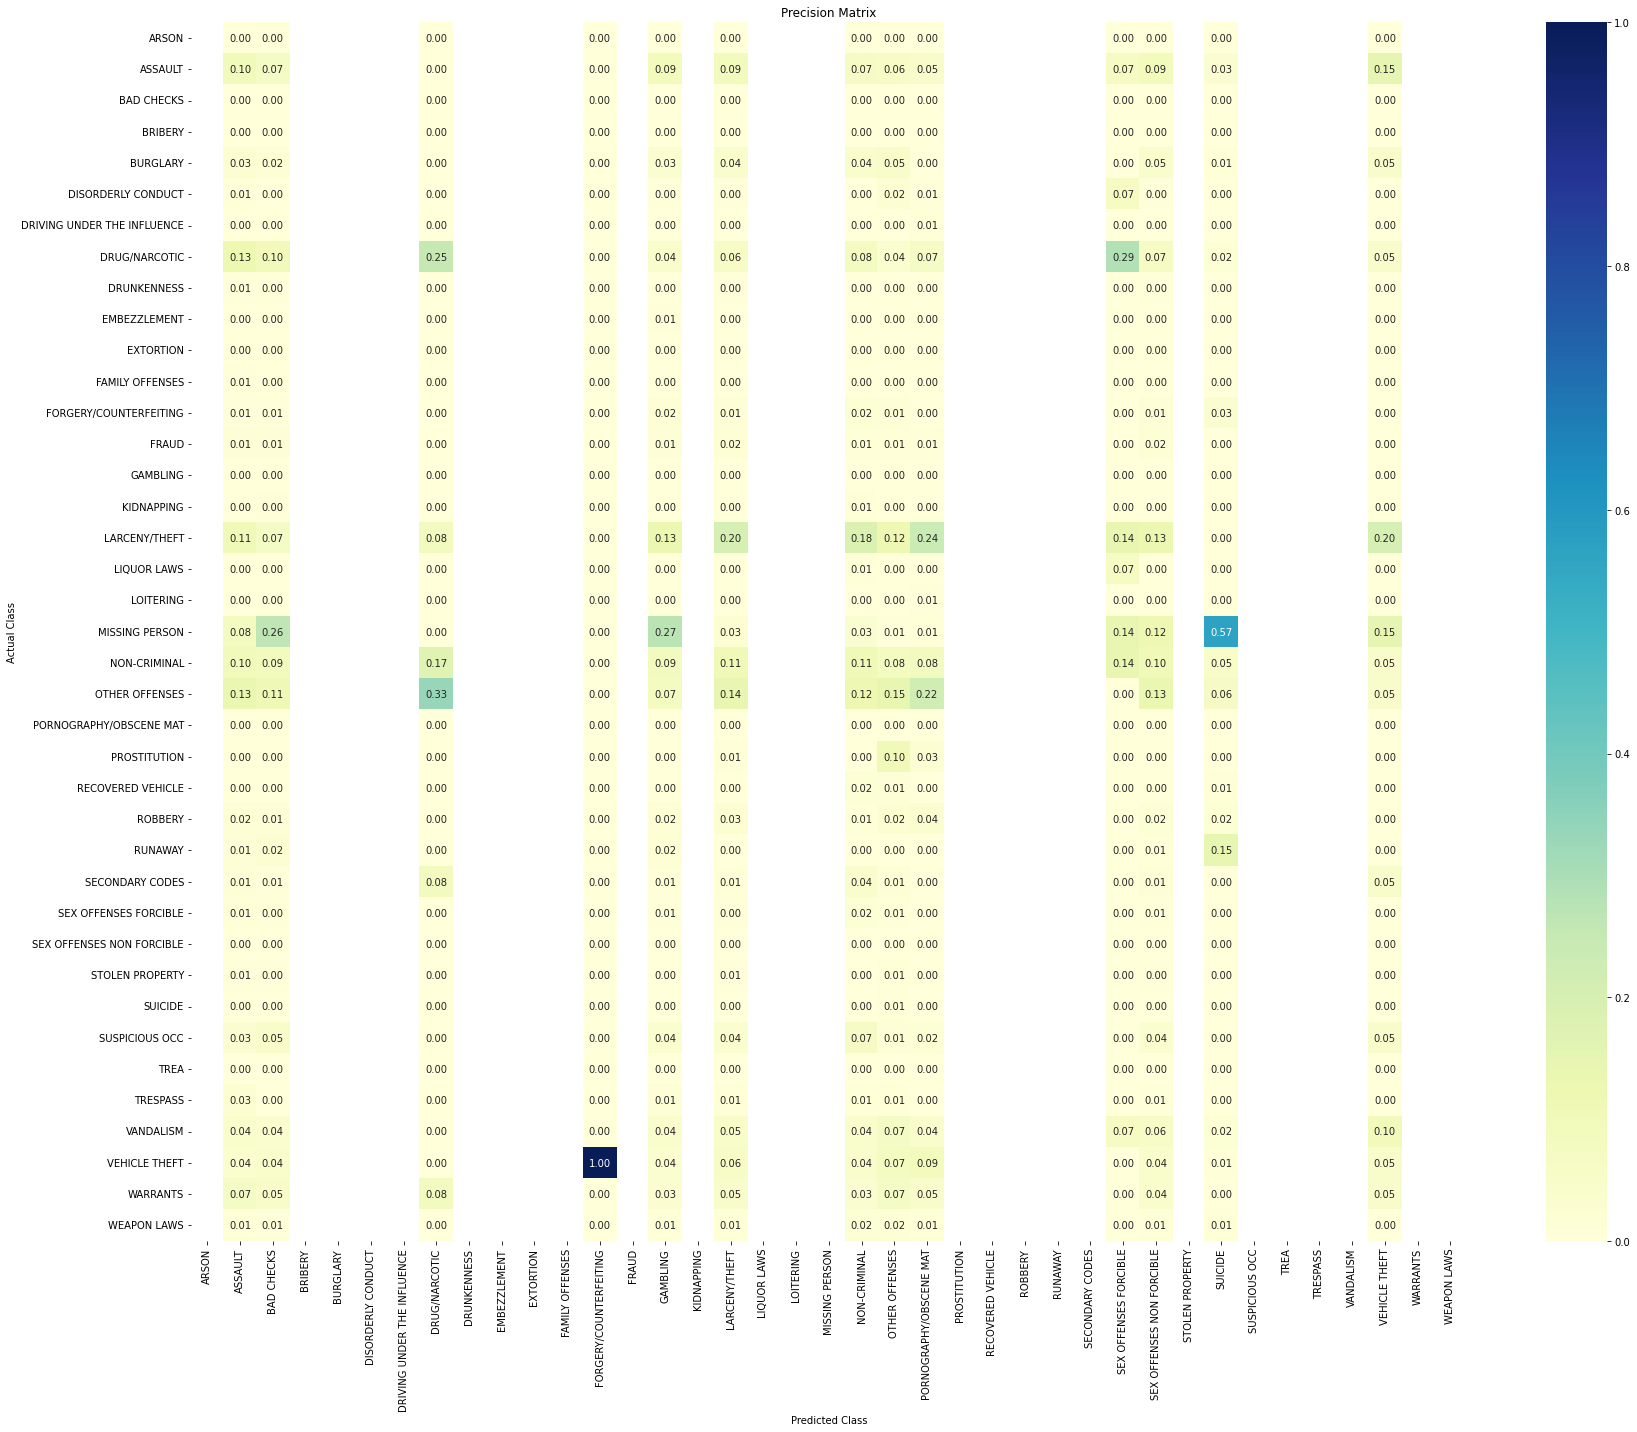

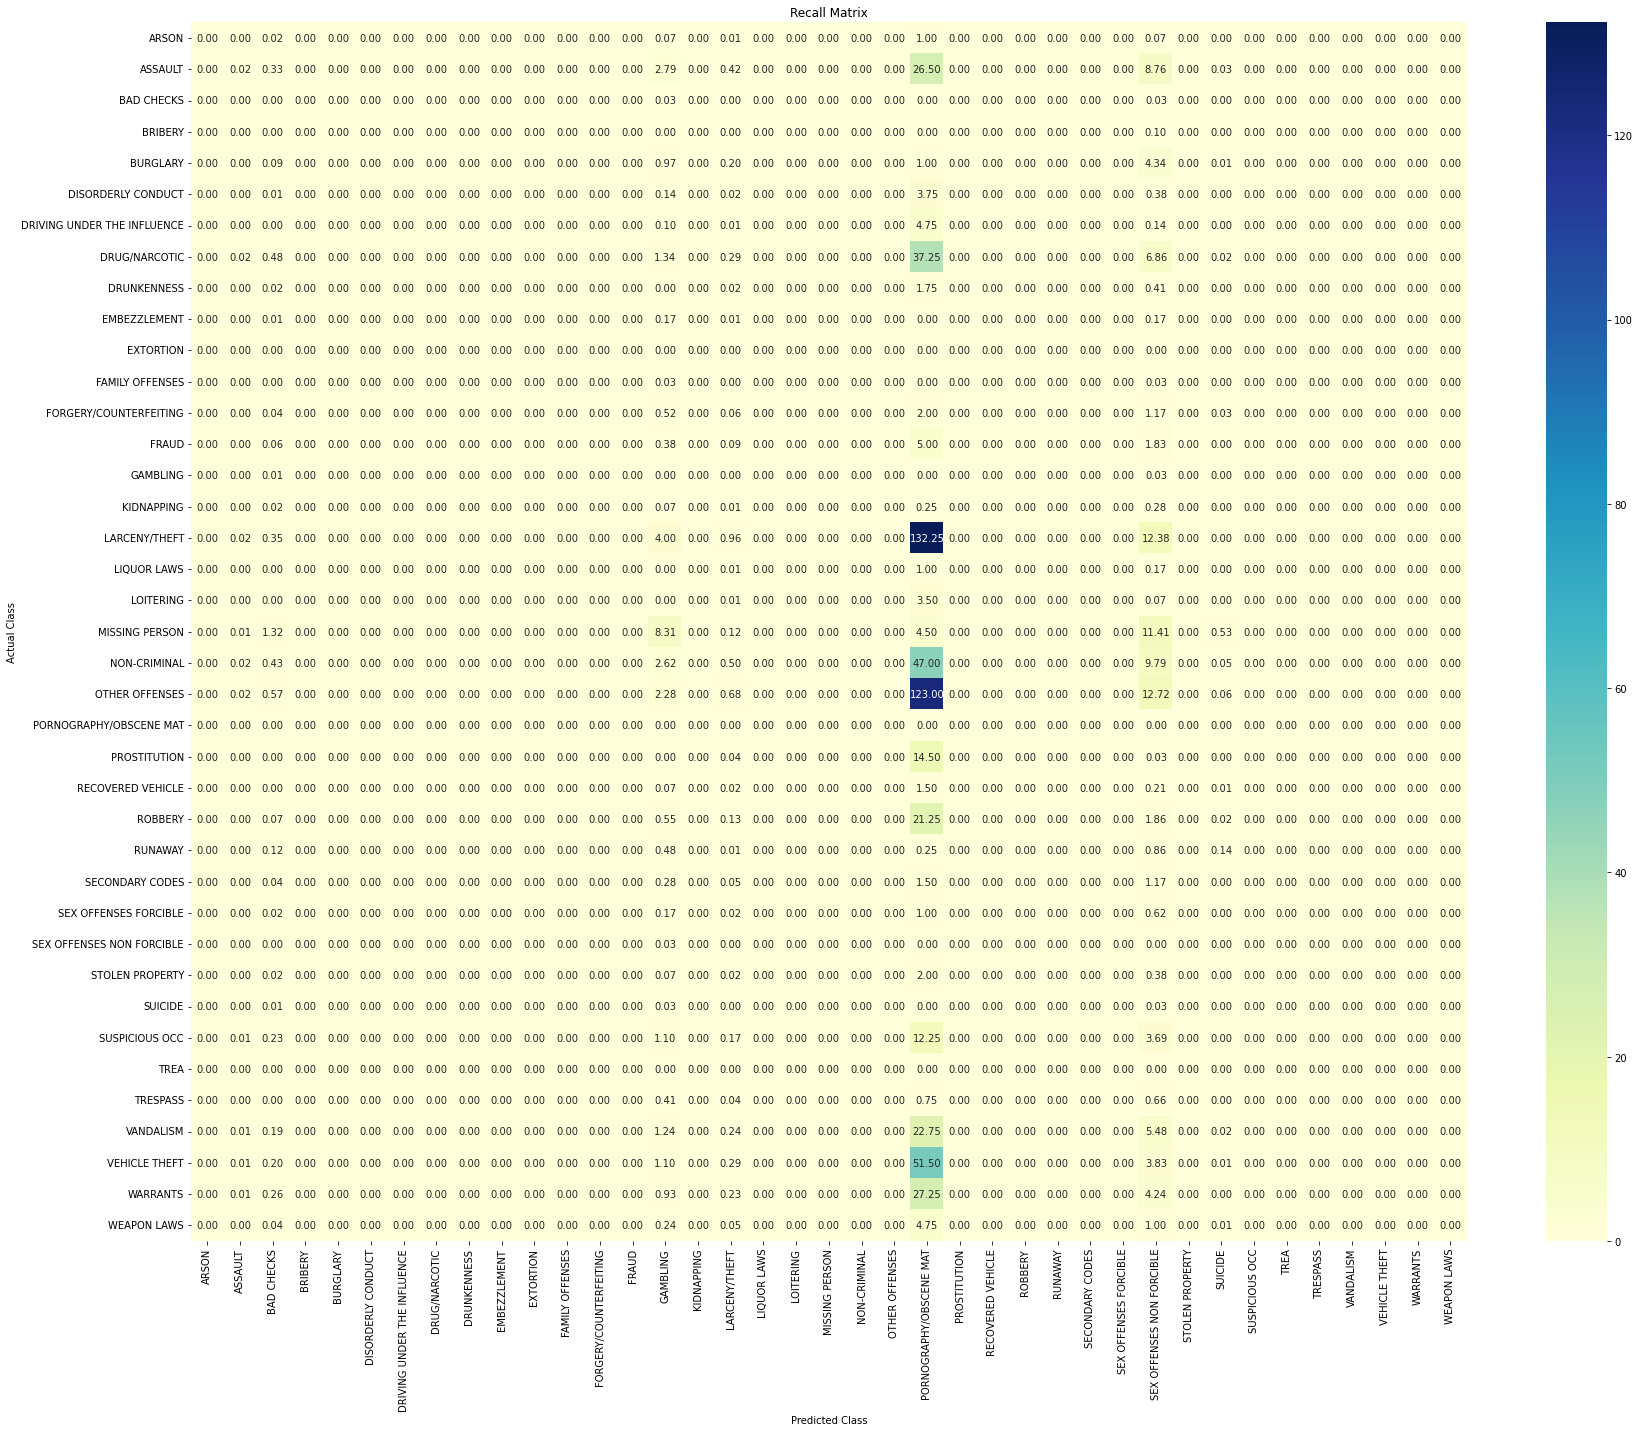

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.10      0.02      0.03     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.25      0.00      0.00     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [21]:
lr_stacked_train_loss, lr_stacked_test_loss = csc.fit_meta_model(meta_model='logistic_regression')

### Random Forest as a Meta Model

Fitting the base model : random_forest
Fitting the base model : decision_tree
Fitting the base model : random_forest
Fitting the base model : decision_tree
Fitting the base model : random_forest
Fitting the base model : logistic_regression
Fitting the base model : xgboost
Fitting the base model : xgboost
(351219, 130)
Fitting the meta model : random_forest
Training Log Loss: 2.6805891312940897
Testing Log Loss: 2.834487978795551


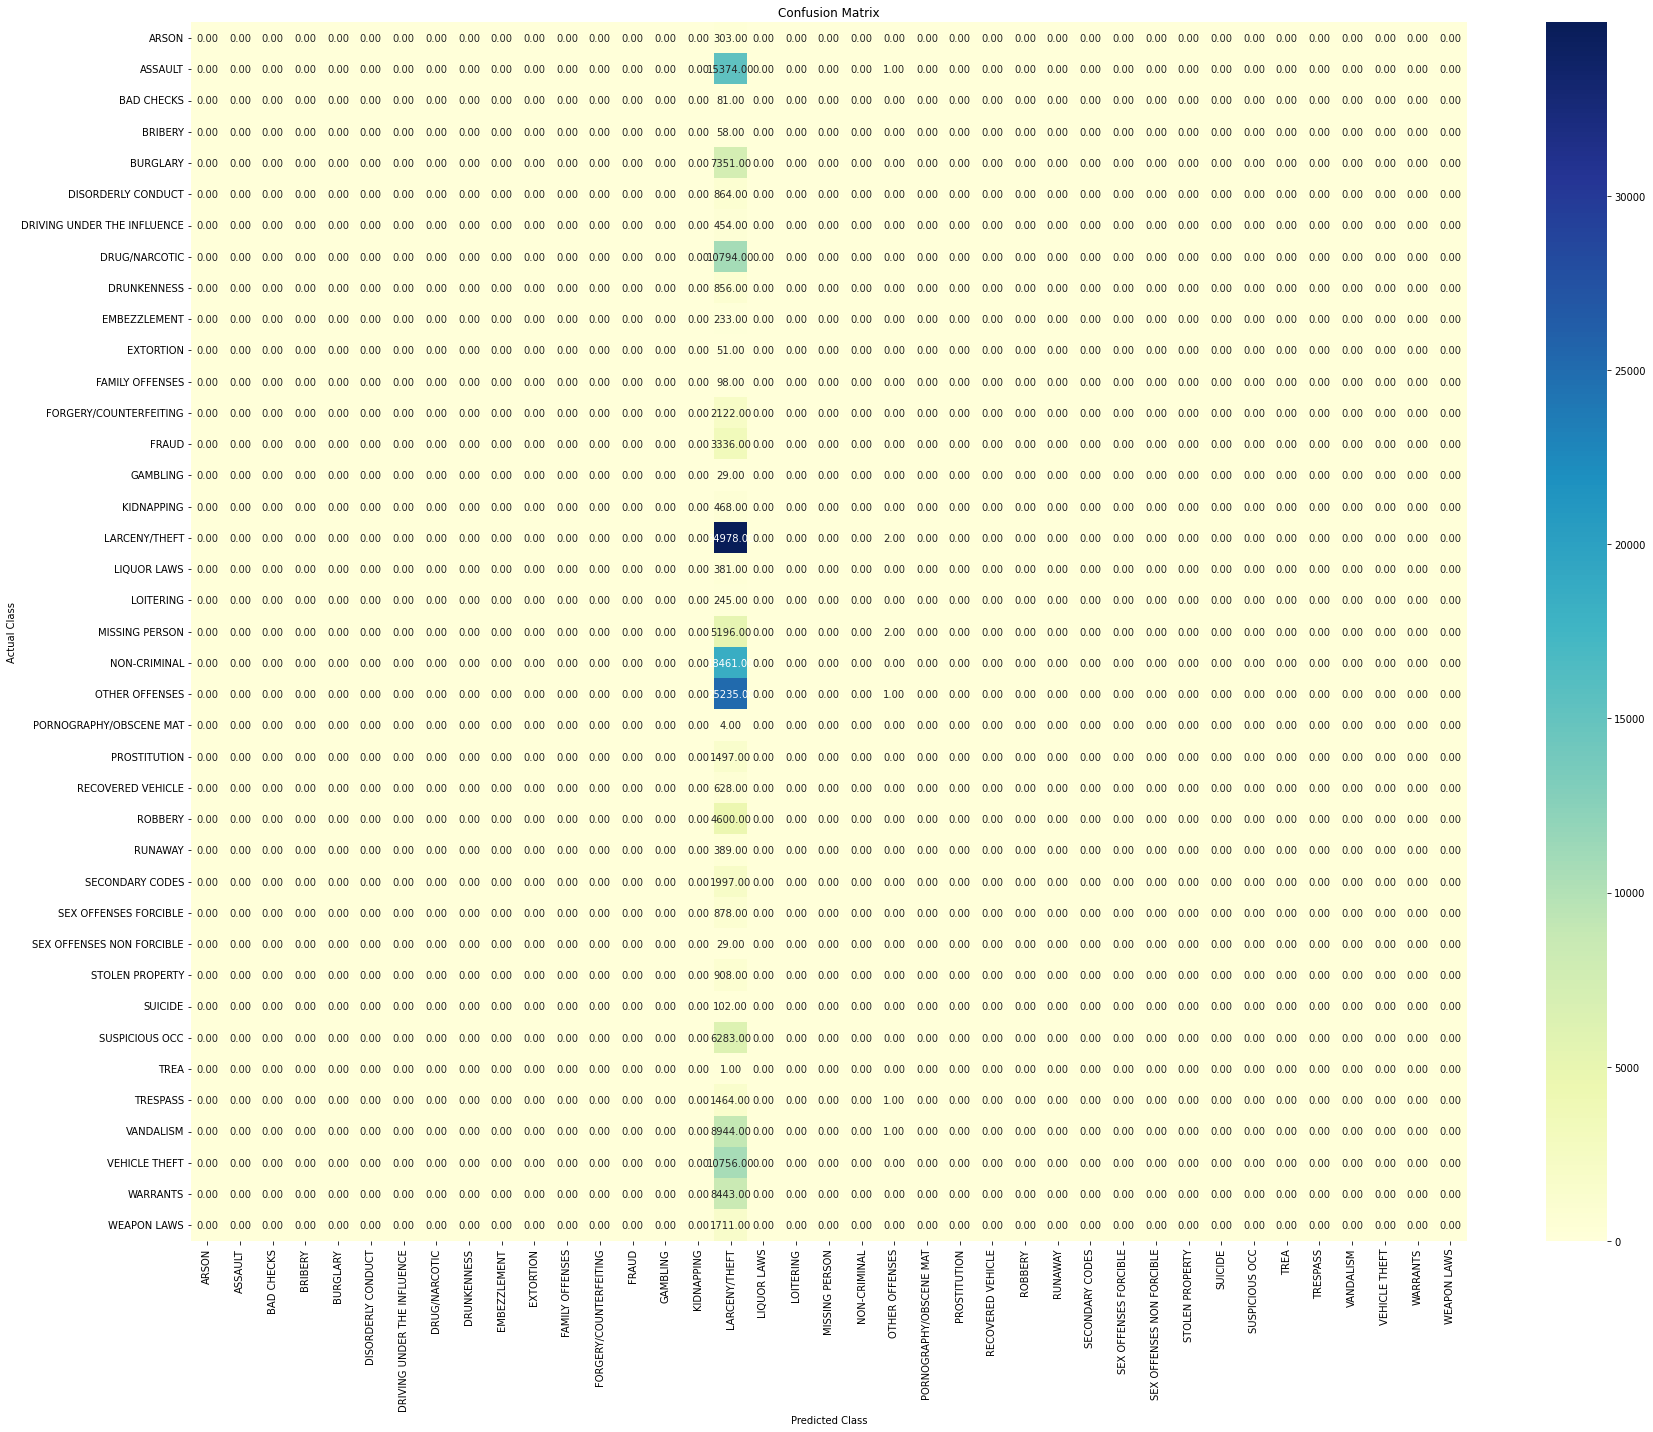

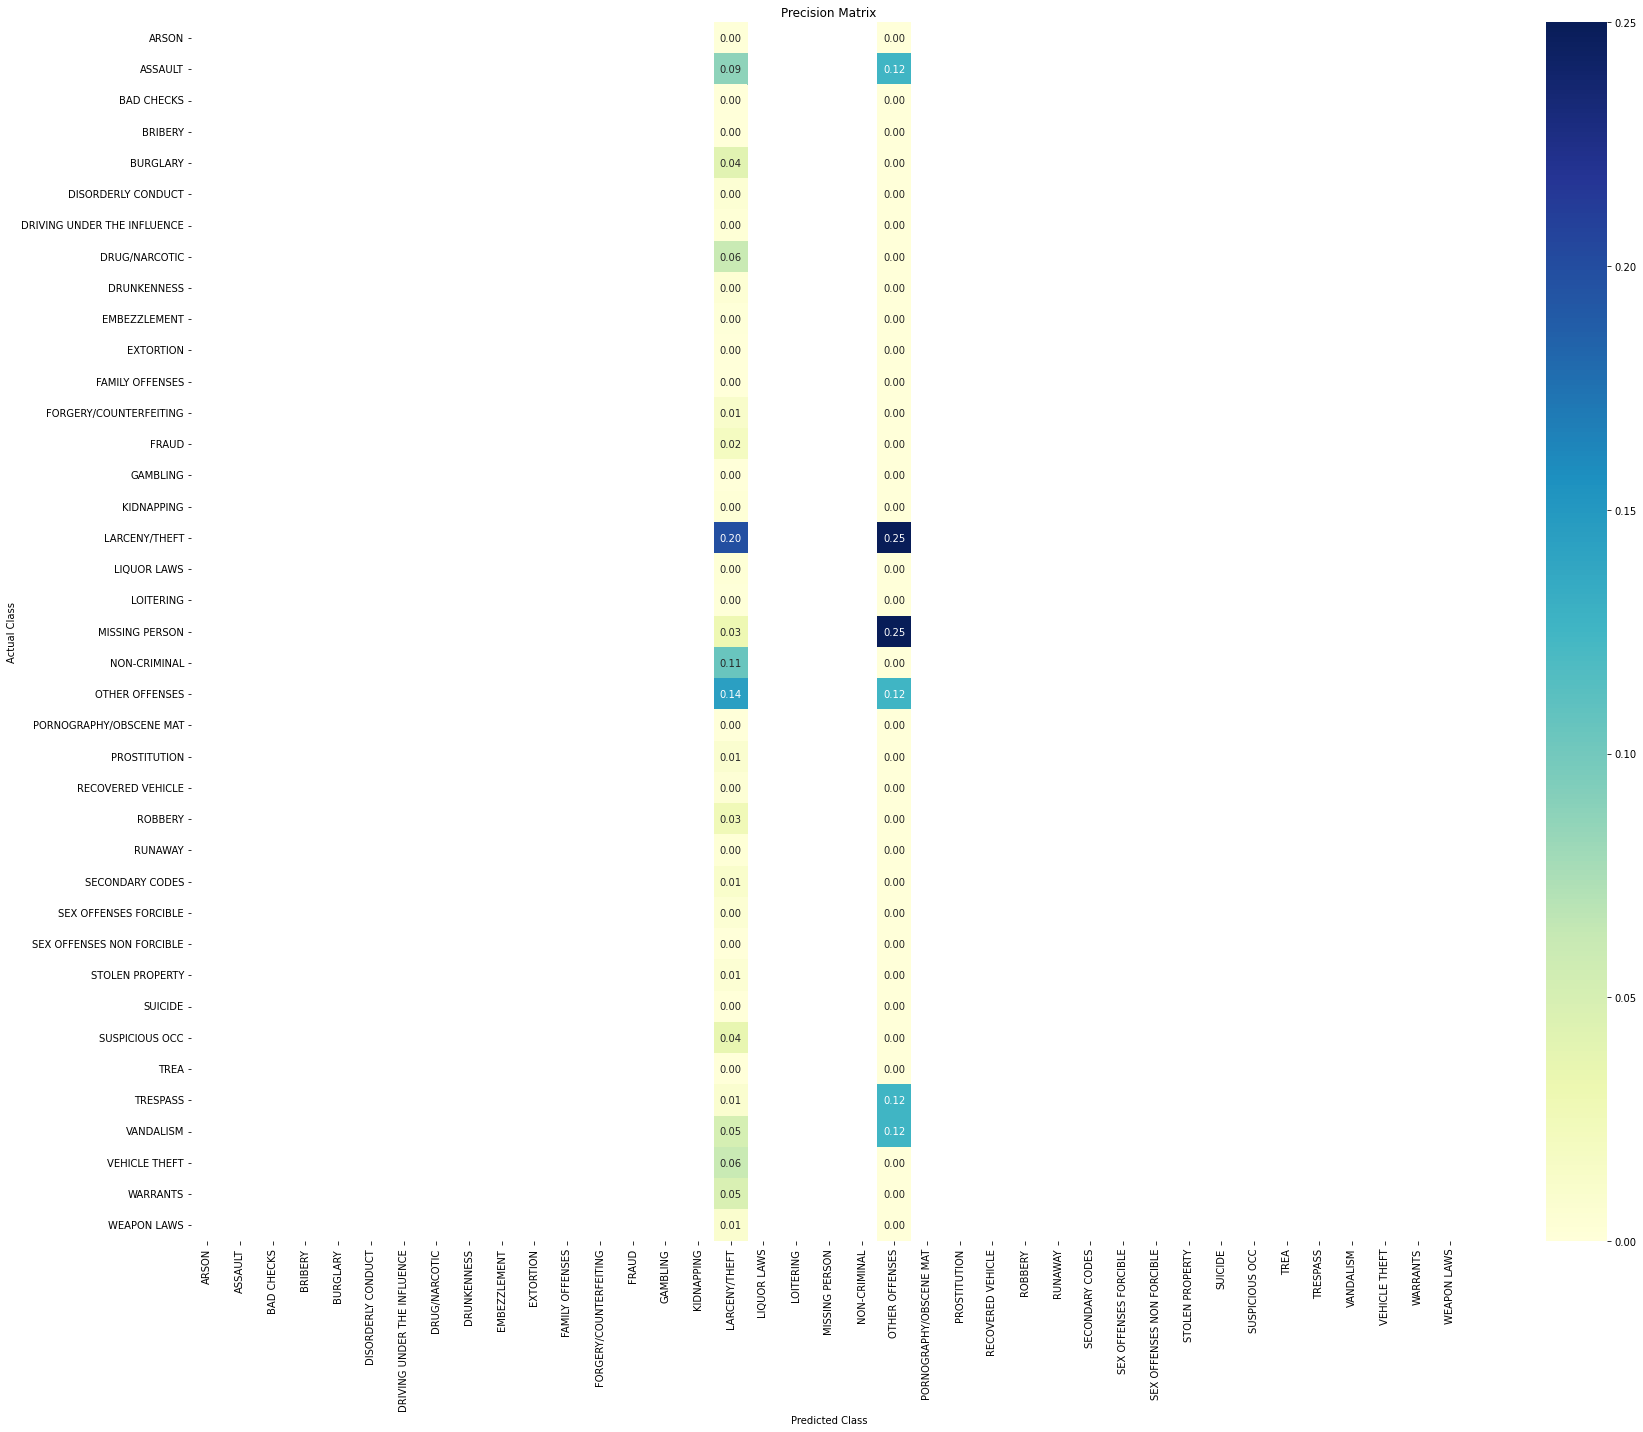

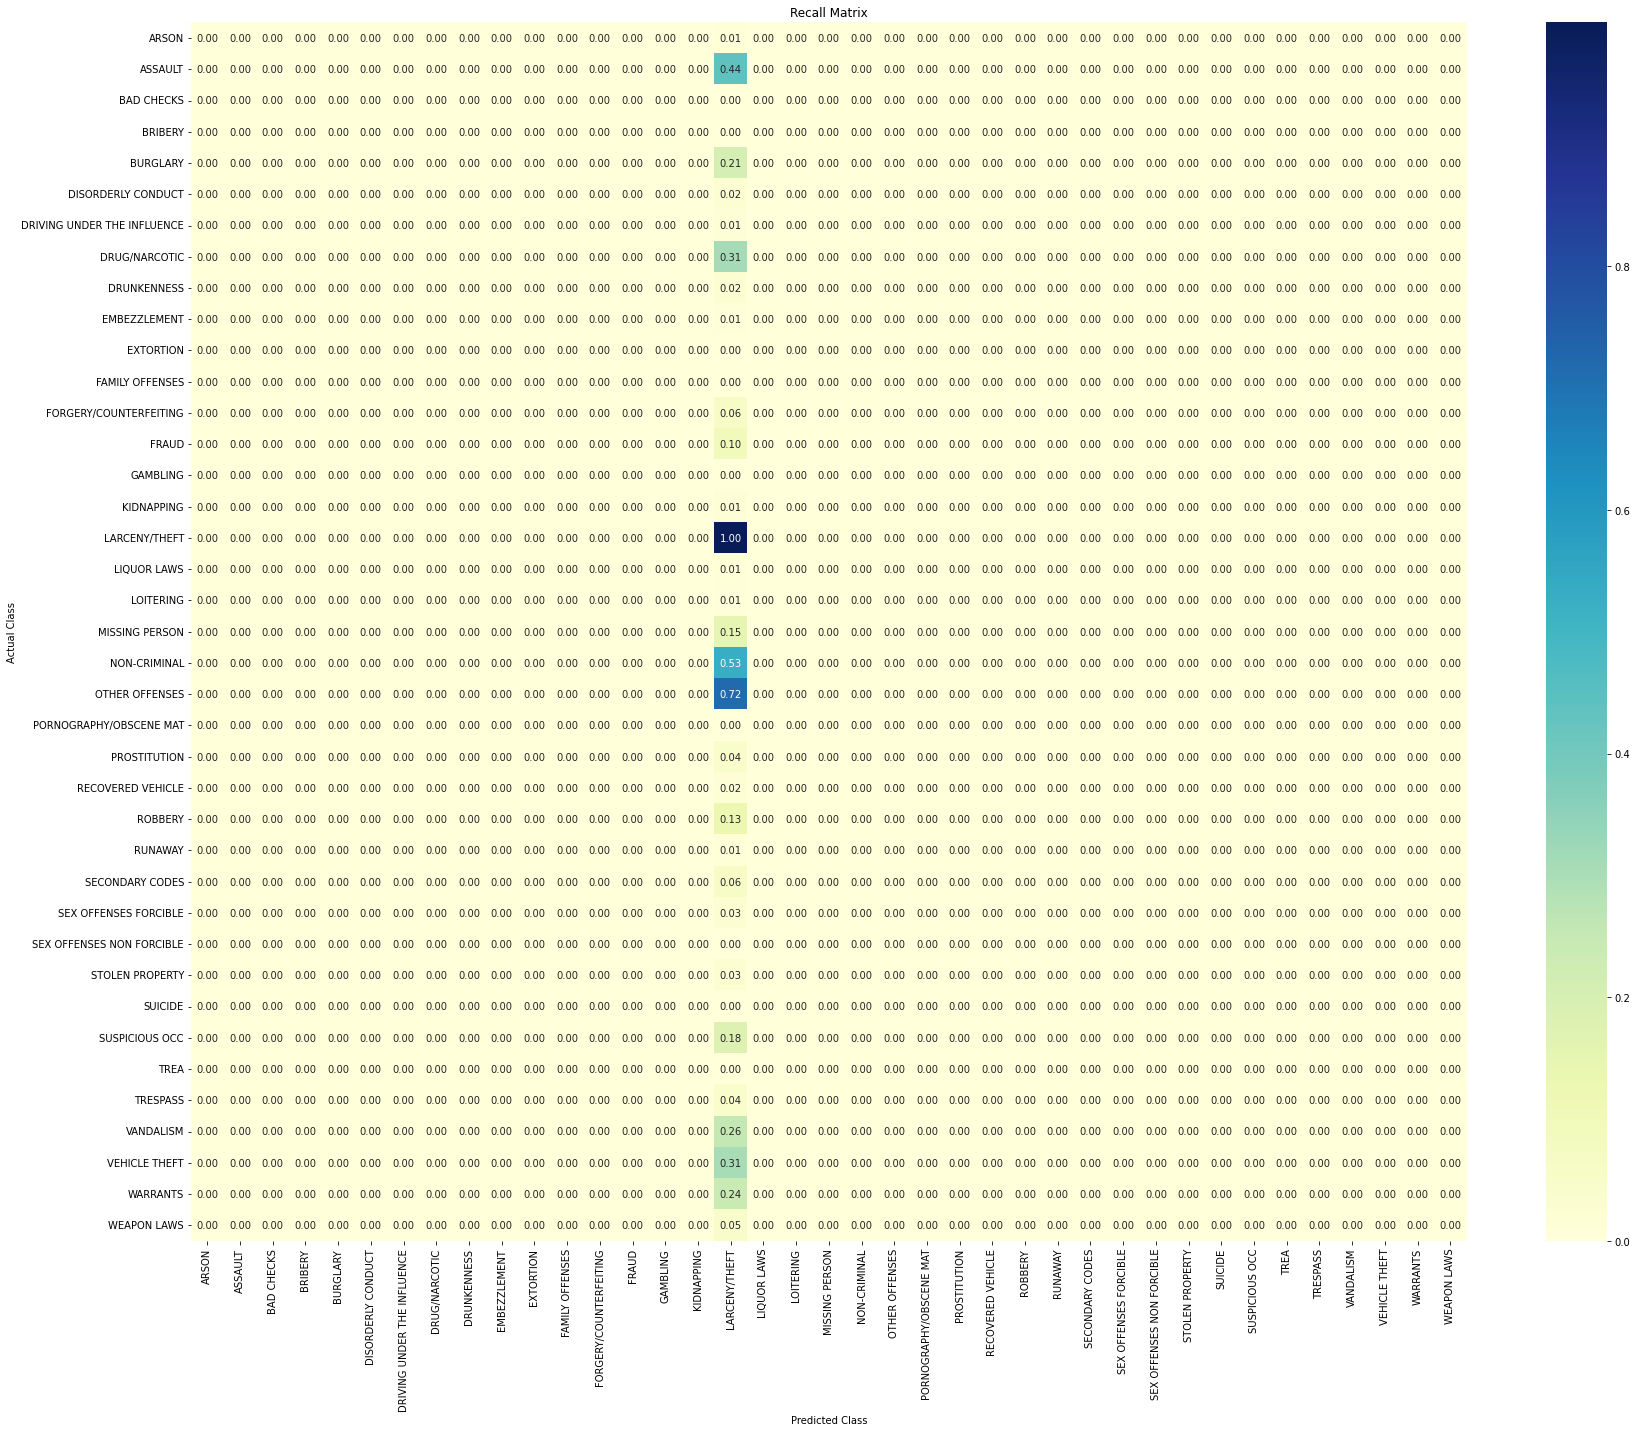

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.00      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.00      0.00      0.00     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [22]:
rf_stacked_train_loss, rf_stacked_test_loss = csc.fit_meta_model(meta_model='random_forest')

### Stacking Summary

In [23]:
model_names = ['Logistic Regression', 'Decision Tree', 'RandomForest', 'XGBoost Classifier']
train_losses = [lr_stacked_train_loss, dt_stacked_train_loss, rf_stacked_train_loss, xgboost_stacked_train_loss]
test_losses = [lr_stacked_test_loss, dt_stacked_test_loss, rf_stacked_test_loss, xgboost_stacked_test_loss]

summary_df = pd.DataFrame()
summary_df['Meta Model'] = model_names
summary_df['Train Loss'] = train_losses
summary_df['Test Loss'] = test_losses

summary = tabulate(tabular_data=summary_df, headers='keys', tablefmt='psql')
print(summary)

+----+---------------------+--------------+-------------+
|    | Meta Model          |   Train Loss |   Test Loss |
|----+---------------------+--------------+-------------|
|  0 | Logistic Regression |      2.68032 |     2.78104 |
|  1 | Decision Tree       |      2.68158 |     2.68055 |
|  2 | RandomForest        |      2.68059 |     2.83449 |
|  3 | XGBoost Classifier  |      1.95707 |     3.72102 |
+----+---------------------+--------------+-------------+


* All the models perform equally same except for `XGBoost` which is overfitting.
* When compared to simple base model implementation without stacking, `XGBoost` does perform really well.